In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.spatial import Voronoi, voronoi_plot_2d
from itertools import combinations # https://docs.python.org/3/library/itertools.html#itertools.combinations

In [ ]:
def perform_rsa(boundaries, num_dim, number_pts, min_dist_func = None,
                dist_func = np.linalg.norm):
  """
  Function: perform random sequential addition (RSA) to generate n RSA points

  Input:
    - boundaries (list of tuples): each tuple in array has the form
      (i_low_lim, i_high_lim) where i_low_lim and i_high_lim represents the
      lower and upper boundary of the ith dimension, respectively

    - num_dim (int): an explicit parameter ensuring that the number of
      dimensions in boundaries is as intended (will throw error otherwise)
    - number_pts (integer): number of points to generate
    - min_dist_func (func): minimum distance between randomly generated points
      (could be a constant or pointer to function)
    - dist_func (pointer to function): distance function/metric to use to find
      distance between points

  Output:
    - all_rsa_pts (float array with dim (number_pts x num_dim)):
      each list is a point generated by RSA
  """

  # check user knows what dimensions they're inputting
  if len(boundaries) != num_dim:
      raise Exception("num dim doesnt agree")

  # for our purposes, we only deal with 2D or 3D
  if num_dim == 2:
    min_dist_func = min_dist_2D
    # if min_dist_func != min_dist_2D:
    #   print("Are you sure you don't mean to use min_dist_2D since num_dim=2?")
  elif num_dim == 3:
    min_dist_func = min_dist_3D

  # generate an array to contain all the points at once
  # first column is x coordinate of ith point/row
  # second column is y coordinate of ith point/row
  # third column ...
  all_rsa_pts = np.empty(shape=(number_pts,num_dim))
  RSA_center = np.empty(shape=(num_dim))
  # for the first point/row, assign valid random values based on boundaries
  for i in range(0, num_dim):
    all_rsa_pts[0,i] = random.uniform(boundaries[i][0],boundaries[i][1])
    RSA_center[i] = (boundaries[i][0] + boundaries[i][1]) / 2

  # the last valid point created is the first one, initialized above.
  # while the next point created is not valid, continue to recreate it, once
  # it is valid, then update index_last_valid_pt by 1 and repeat until
  # index_last_valid_pt = number_pts-1
  # which entails that the last row/element/point in the all_rsa_pts is valid
  # i.e. all points are now valid
  index_last_valid_pt = 0
  # generate the next random pt
  while index_last_valid_pt < number_pts-1:
    cur_pt_idx = index_last_valid_pt+1

    # select a slice from the initialized array (a numpy "view")
    cur_rand_pt = all_rsa_pts[cur_pt_idx,:]

    for i in range(0,num_dim):
      # generate the value for dimension i
      cur_rand_pt[i] = random.uniform(boundaries[i][0],boundaries[i][1])

    # ensure that point's distance to already-present points is acceptable,
    # range over all the valid points so far
    acceptable_dist = True
    for other_pt_idx in range(0,index_last_valid_pt+1):

      # never compare the point against itself, otherwise infinite loop
      if other_pt_idx == cur_pt_idx:
        continue

      # slice out the other point
      other_pt = all_rsa_pts[other_pt_idx,:]

      if dist_func(other_pt - cur_rand_pt) < min_dist_func(cur_rand_pt,RSA_center):
          # stop early, if one point is too close, then this cur_rand_pt is not
          # acceptable
          acceptable_dist = False
          break

    # add the point if its valid
    if acceptable_dist:
      # a valid point has been selected, advance to the next index
      index_last_valid_pt += 1

  print("RSA_center:",RSA_center)
  return all_rsa_pts, RSA_center

def min_dist_2D(pt, center):
  return 0.146 * np.linalg.norm(pt - center) ** (1/3)

def min_dist_3D(pt, center):
  return 0.146 * np.linalg.norm(pt - center) ** (2/3)

In [ ]:
def create_all_pairs_from_simplex(simplex):
  # if we let length of simplex = s, then to get all pairs we have
  # sC2 which is read as "s choose 2" in combinatorics
  return combinations(simplex,2)

In [ ]:
def create_adjacency_matrix_from_simplices(simplices,number_pts):
  """
  Input:
  - simplices (np.ndarray): contains all the points defining the vertices of the
  triangulation which in turn defines nearest neighbors (output from
  Delaunay(set of points))
  - number_pts (int): number of points in the consideration

  Output:
  - adjacency matrix (np.ndarray): dimensions (number_pts x number_pts),
  with a 1 at (row_idx, col_idx) and (col_idx,row_idx) then the point
  represented by row_idx and the point represented by col_idx are neighbors in
  the Delunay Triagnulation
  """
  # initialize adjacency matrix (avoid doing empty this time,
  # since if they are NOT neighbors, then we want zeros)
  adjacency_mtx = np.zeros(shape=(number_pts,number_pts))

  # range over all the simplices
  for simplex in simplices:

      # look at each neighbor pair within the simplex
      for neighbor_pair in create_all_pairs_from_simplex(simplex):
        point_1_idx = neighbor_pair[0]
        point_2_idx = neighbor_pair[1]

        # assign 1 to the entry corresponding to point_1 and point_2
        adjacency_mtx[point_1_idx,point_2_idx] = 1
        # with our defintion of "neighbors"
        # the adjacency matrix is symmetrical. if point_1 is neighbor of point_2
        # then that means point_2 is a neighbor of point_1 (note for kNN this
        # may not be true in general, so neighbors must be defined carefully)
        adjacency_mtx[point_2_idx,point_1_idx] = 1

  return adjacency_mtx

In [ ]:
def get_point_nearest_center(all_pts, RSA_center):
    min_dist_from_center = np.inf
    best_idx = None

    for idx, pt in enumerate(all_pts):
        # calculate distance between point and center
        dist = np.linalg.norm(pt - RSA_center)

        if dist < min_dist_from_center:
          #Save the min_dist and best_idx
            min_dist_from_center = dist
            best_idx = idx

    best_pt = all_pts[best_idx]
    return best_idx, best_pt


def create_initial_states(number_pts, num_dim, RSA_center, tri):
  """
  DESCRIPTION: create the array describing the state for each initial point. the
  ith index in the tri.points attribute is defined by the state at the ith
  element in the cell_states_array. see note below on states

  NOTE, STATES ARE DEFINED AS FOLLOWS:
  - 0: empty cellular automaton cell (non-tumorous biological cells)
  - 1: cancerous, proliferative cellular automaton cell
  - 2: cancerous, non-proliferative, non-necrotic cellular automaton cell
  - 3: cancerous, necrotic cellular automaton cell

  INPUT:
  - number_pts (int): number of cellular automaton cells
  - num_dim (array): number of dimensions for the cells. i.e. 2d or 3d
  - RSA_center (array): point indicating the center of the RSA space

  OUTPUT:
  - cell_states_array (ndarray): size (1 x number_pts), where the ith entry
  corresponds to the ith point's state
  """

  cell_states_array = np.zeros(shape=(number_pts))

  all_pts = tri.points

  # assign the first progenitor cell
  center_of_tumor_idx, center_of_tumor_pt = get_point_nearest_center(all_pts,RSA_center)

  cell_states_array[center_of_tumor_idx] = 1

  return cell_states_array, center_of_tumor_idx, center_of_tumor_pt

In [ ]:
import copy
def simulate_system(num_dim,t,init_states,a,b,tri,R_max,p_0,adjacency_mtx,center_of_tumor_pt,center_of_tumor_idx):
  all_results = [init_states]

  if num_dim != len(center_of_tumor_pt) or num_dim != len(tri.points[0]):
    error_string = f"""
    ERROR: Dimensions DO NOT MATCH
    center_of_tumor_pt = {center_of_tumor_pt}
    tri.points[0] = first_pt = {tri.points[0]}
    BUT
    num_dim = {num_dim}
    """
    raise Exception(error_string)

  # for our purposes, we only deal with 2D or 3D
  if num_dim == 2:
    calc_delta_p_func = calc_delta_p_2D
    calc_delta_n_func = calc_delta_n_2D
  elif num_dim == 3:
    calc_delta_p_func = calc_delta_p_3D
    calc_delta_n_func = calc_delta_n_3D
  #Get the coordinates of the centers of all cells in the triangulation
  all_points = tri.points
  # #In the initial state, only one cell is proliferative, find its index and coordinates
  # center_of_tumor_idx = np.where(init_states==1)[0][0]
  # center_of_tumor = tumor_center
  #Range over time steps
  for timestep in range(t):
    #Calculate R_t
    R_t = calc_Rt(center_of_tumor_pt,all_points,init_states,adjacency_mtx)
    check_no_prolif_cells = (R_t == np.inf)

    if check_no_prolif_cells:
      break # exit timesteps early

    # CURRENT TIMESTEP PARAMETERS:
    #Create a copy of the current_states. This will be updated in this time step
    new_states = copy.deepcopy(init_states)
    #Calculate delta_n
    delta_n = calc_delta_n_func(a,R_t)
    #If it can spread, calculate delta_p
    delta_p = calc_delta_p_func(b,R_t)
    # calculate necrotic region radius
    necrotic_radius = R_t - delta_p - delta_n

    #Iterate over all cells in the current time step
    for cell_idx, cell in enumerate(init_states):

      #Get the coordinates of the current cell
      cell_pt = all_points[cell_idx]
      #Calculate the distance of the current cell from tumor center r_i
      r_i = np.linalg.norm(center_of_tumor_pt - cell_pt)

      #If cell is non-proliferative, check if it will turn necrotic
      if ((cell == 2) & (r_i < necrotic_radius)):
        new_states[cell_idx] = 3
        #Else if the cell is proliferative, check if it can spread
      elif cell == 1:
        #Check probabilistically if it is allowed to spread.
        if np.random.random() < (calc_prob_division(p_0,r_i,R_max)):
          #Find neighbors of this cell in NEW BOARD
          neighbor_idxs = np.where(adjacency_mtx[cell_idx,:]==1)[0]
          # neighbor_states = new_states[neighbor_idxs]
          neighbor_xy = all_points[neighbor_idxs]
          #Iterate over neighbors and check if any neighbor is within delta_p distance
          divide = False
          for nbr_idx, nbr_pt in zip(neighbor_idxs,neighbor_xy):
            # print("np.linalg.norm(cell_pt - nbr_pt)",np.linalg.norm(cell_pt - nbr_pt),
            #       "delta_p",delta_p)
            if np.linalg.norm(cell_pt - nbr_pt) < delta_p:
              #If it is, check what the state of the neighbor is
              nbr_cell_state = init_states[nbr_idx]
              if nbr_cell_state == 0:#neighbor is a non-tumor cell
                new_states[nbr_idx] = 1#Infect
                divide = True
                break
          if not divide:
            new_states[cell_idx] = 2#It cannot infect any cell, make current cell non-proliferative <- Check the logic here
    # save the updated lattice for next timestep
    init_states = new_states
    # save the result after updating all the cells from previous timestep
    all_results.append(init_states)

  if check_no_prolif_cells:
      print(f"No more proliferative cells left, stopped at timestep={timestep}")
  return all_results

In [ ]:
def calc_delta_p_3D(b,R_t):
  delta_p = b*(R_t** (2/3))
  return delta_p

def calc_delta_n_3D(a,R_t):
  delta_n = a*(R_t** (2/3))
  return delta_n

def calc_delta_p_2D(b,R_t):
  delta_p = b*(R_t** (1/2))
  return delta_p

def calc_delta_n_2D(a,R_t):
  delta_n = a*(R_t** (1/2))
  return delta_n

In [ ]:
def calc_prob_division(p_0,r_i,R_max):
  p_d = p_0*(1-(r_i/R_max))
  return p_d

In [ ]:
def get_proliferative_cell_idxs(cur_state_array):
  idxs = np.where(cur_state_array == 1 )[0]
  return idxs#"BLAH"

def calc_Rt(tumor_center, all_points, cur_state_array, adjacency_mtx):
  # print("cur_state_array",cur_state_array,"\n\n")
  # get all the proliferative cell indices and points
  proliferative_cell_idxs = get_proliferative_cell_idxs(cur_state_array)
  proliferative_cell_pts = all_points[proliferative_cell_idxs]

  # edge points are proliferative cells with at least one healthy cell (state 0) as a neighbor
  edge_pts = []
  for cell_idx, cell_pt in zip(proliferative_cell_idxs, proliferative_cell_pts):
    neighbor_idxs = np.where(adjacency_mtx[cell_idx,:]==1)[0]

    # print("neighbor_idxs",neighbor_idxs,"\n\n")

    if 0 in cur_state_array[neighbor_idxs]:
      edge_pts.append(cell_pt)
  edge_pts = np.array(edge_pts)
  # print("edge_pts",edge_pts,"\n\n")
  N_p = len(edge_pts)

  # initialize variable to track running sum
  sums = 0

  for cell_pt in edge_pts:
    r_i = np.linalg.norm(cell_pt - tumor_center)

    # handle the edge case where the center is the only proliferative cell
    # in the boundary proliferative cells
    if r_i == 0 and len(edge_pts) == 1:
      r_i = 1
      N_p = 1

    # print("tumor_center",tumor_center)
    sums += r_i

  if N_p == 0:
    return np.inf

  return sums/N_p

In [ ]:
# reordered_states=[]
# reordered_states.append(center_of_tumor)
# neighbor_idxs = adjacency_mtx[center_of_tumor_idx,:]
# neighbor_pts = init_states[neighbor_idxs]
# reordered_states += neighbor_pts
# nbr_of_nbrs = []
# for nbr in reordered_states[1:]:
#   nbr_idx = np.where(all_points == nbr)[0][0]
#   neighbor_idxs = adjacency_mtx[nbr_idx,:]
#   neighbor_pts = new_states[neighbor_idxs]
#   for pt in neighbor_pts:
#     if (pt not in nbr_of_nbrs) & (pt not in reordered_states):
#       nbr_of_nbrs.append(pt)


In [ ]:
# model parameters

# 2d parameters

# # from pg 17 of thesis, did not work
# a_2d = 0.17
# b_2d = 0.98

# # also from pg 17 of thesis, did not work
# a_2d = 0.42
# b_2d = 0.11

# this works
a_2d = 0.9
b_2d = 2
p_0_2d = 0.6
R_max_2d = 37.5

# 3d parameters
a_3d=0.42
b_3d = 0.11
p_0_3d = 0.192
R_max_3d = R_max_2d

In [ ]:
x_lim = R_max_2d*1.05
y_lim = x_lim
boundaries = [(-x_lim, x_lim), (-y_lim, y_lim)]
num_dim = 2
number_pts = 2000

# RSA inputs
# perform the RSA
small_set, RSA_center = perform_rsa(boundaries, num_dim, number_pts)
x_vals = small_set[:,0]
y_vals = small_set[:,1]

# create Voronoi and Delaunay plot with overlay
tri = Delaunay(small_set)
init_states, center_of_tumor_idx, center_of_tumor_pt = create_initial_states(number_pts, num_dim, RSA_center=RSA_center, tri=tri)

adjacency_mtx = create_adjacency_matrix_from_simplices(simplices=tri.simplices,number_pts=number_pts)

RSA_center: [0. 0.]


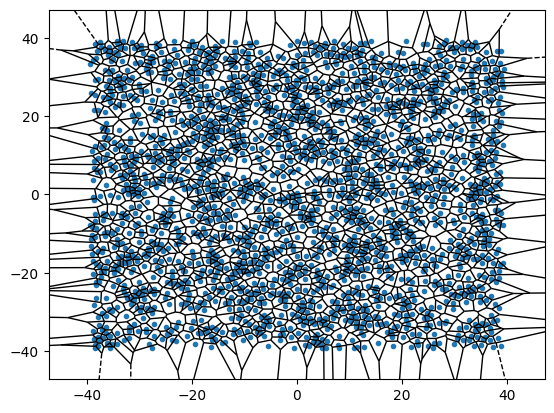

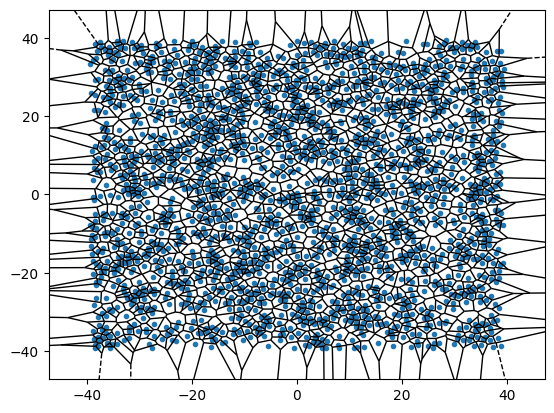

In [ ]:
vor = Voronoi(small_set)
voronoi_plot_2d(vor, show_vertices = False)

In [ ]:
# for row in adjacency_mtx:
#   print(row)

In [ ]:
# run the model
all_timesteps = []
while len(all_timesteps) < 101:
  all_timesteps = simulate_system(num_dim=2,t=100,init_states=init_states,a=a_2d,
                                b=b_2d,tri=tri,R_max=R_max_2d,
                                p_0=p_0_2d,adjacency_mtx = adjacency_mtx,
                                center_of_tumor_pt = center_of_tumor_pt,
                                center_of_tumor_idx = center_of_tumor_idx)

  print("total timesteps:",len(all_timesteps))

total timesteps: 101


In [ ]:
all_timesteps[-1]

In [ ]:
np.where(all_timesteps[-1]==1)

# VISUALIZE RESULTS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# cell_labels = np.random.choice(["necrotic-core", "proliferative", "non-proliferative", "non-tumorous"], size=20)

states_to_labels_dict = {0:"non-tumorous", 1:"proliferative", 2:"non-proliferative", 3:"necrotic-core"}
cell_labels = [states_to_labels_dict[state_val] for state_val in all_timesteps[-1]]

color_map = {"necrotic-core": "dimgray", "proliferative": "lightcoral", "non-proliferative": "firebrick", "non-tumorous": "cornflowerblue"}

fig, ax = plt.subplots(1)
vor = Voronoi(small_set)
v_fig = voronoi_plot_2d(vor, show_vertices = False, ax = ax)

for r in range(len(vor.point_region)):
    region = vor.regions[vor.point_region[r]]
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), color=color_map[cell_labels[r]])
        # print(cell_labels[r])

# ax.triplot(x_vals, y_vals)
ax.plot(x_vals, y_vals, 'o')

# Create custom legend for cell categories
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
                   for label, color in color_map.items()]

plt.legend(handles=legend_elements, loc='upper right', title='Cell Types')
# -0.23179961 -4.37262845
plt.show()

NameError: ignored

In [ ]:
def plot_current_timestep(states_to_labels_dict,cur_timestep_states, all_rsa_points,t=None):
  cell_labels = [states_to_labels_dict[state_val] for state_val in cur_timestep_states]
  fig, ax = plt.subplots(1,figsize=(8, 4))

  color_map = {"necrotic-core": "dimgray", "proliferative": "lightcoral", "non-proliferative": "firebrick", "non-tumorous": "cornflowerblue"}
  vor = Voronoi(all_rsa_points)
  v_fig = voronoi_plot_2d(vor, show_vertices = False, ax = ax, show_points = False, line_colors = 'steelblue')

  for r in range(len(vor.point_region)):
      region = vor.regions[vor.point_region[r]]
      if not -1 in region:
          polygon = [vor.vertices[i] for i in region]
          plt.fill(*zip(*polygon), color=color_map[cell_labels[r]])

  ax.plot(x_vals, y_vals, 'ok',markersize=1)

  # Create custom legend for cell categories
  legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
                    for label, color in color_map.items()]

  if t != None:
    plt.title(f't={t}')
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',handles=legend_elements, title='Cell Types')
  plt.tight_layout()
  plt.show()

# def plot_current_timestep(states_to_labels_dict,cur_timestep_states, all_rsa_points, fig, ax):
#   cell_labels = [states_to_labels_dict[state_val] for state_val in cur_timestep_states]
#   # fig, ax = plt.subplots(1,figsize=(8, 4))

#   color_map = {"necrotic-core": "dimgray", "proliferative": "lightcoral", "non-proliferative": "firebrick", "non-tumorous": "cornflowerblue"}
#   vor = Voronoi(all_rsa_points)
#   v_fig = voronoi_plot_2d(vor, show_vertices = False, ax = ax, show_points = False, line_colors = 'steelblue')

#   for r in range(len(vor.point_region)):
#       region = vor.regions[vor.point_region[r]]
#       if not -1 in region:
#           polygon = [vor.vertices[i] for i in region]
#           ax.fill_between(*zip(*polygon), color=color_map[cell_labels[r]])

#   ax.plot(x_vals, y_vals, 'ok',markersize=1)

#   # # Create custom legend for cell categories
#   # legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
#   #                   for label, color in color_map.items()]

#   # plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',handles=legend_elements, title='Cell Types')
#   # plt.tight_layout()
#   # plt.show()

In [ ]:
center_of_tumor_pt
# tri.points

In [ ]:
# num_timesteps = len(all_timesteps)
# ten_percent = int(num_timesteps/10)

total_steps = len(all_timesteps)
print("total number of steps:",total_steps)

for idx, timestep_states in enumerate(all_timesteps):

  # plots the first and then every 10th timestep
  if idx % 25 == 0:
    plot_current_timestep(states_to_labels_dict=states_to_labels_dict,
                          cur_timestep_states=timestep_states,
                          all_rsa_points=small_set,
                          t=idx)


  # if there's less than 10 timesteps, plot them all
  if total_steps < 10 and idx != 0:
    plot_current_timestep(states_to_labels_dict=states_to_labels_dict,
                          cur_timestep_states=timestep_states,
                          all_rsa_points=small_set,
                          t=idx)

plt.show()

In [ ]:
len(all_timesteps)

In [ ]:
int(140/10)

14 % 14

In [ ]:
a_low = 0.1
a_high = 2
b_low = 0.1
b_high = 2

a_axis = np.linspace(start=a_low,stop=a_high,num=13)
b_axis = np.linspace(start=b_low,stop=b_high,num=13)
a_pts, b_pts = np.meshgrid(a_axis,b_axis)

sim_length_to_a_and_b_tuple_dict = {}

num_attempts = 10

for row_idx, _ in enumerate(a_pts):
  print("doing row_idx =",row_idx)
  for col_idx, _ in enumerate(a_pts[0]):
    a = a_pts[row_idx,col_idx]
    b = b_pts[row_idx,col_idx]
    # print(a,b)

    # print(row_idx,col_idx)

    # run the model "num_attempts" times
    avg_num_timesteps = 0
    for i in range(num_attempts):
      print(f"attempt: {i}")
      all_timesteps = simulate_system(num_dim=2,t=100,init_states=init_states,a=a,
                                    b=b,tri=tri,R_max=R_max_2d,
                                    p_0=p_0_2d,adjacency_mtx = adjacency_mtx,
                                    center_of_tumor_pt = center_of_tumor_pt,
                                    center_of_tumor_idx = center_of_tumor_idx)

      avg_num_timesteps += len(all_timesteps)

    avg_num_timesteps /= num_attempts
    a_and_b_tuple = (a,b)

    empty_list = [0]

    current_dict_entry = sim_length_to_a_and_b_tuple_dict.get(avg_num_timesteps,empty_list)

    if current_dict_entry[0] == 0:
      current_dict_entry = [a_and_b_tuple]
      sim_length_to_a_and_b_tuple_dict[avg_num_timesteps] = current_dict_entry
      # print(f"initializing num_timesteps={num_timesteps} with (a,b)=({a},{b})")
    else:
      current_dict_entry.append(a_and_b_tuple)
      sim_length_to_a_and_b_tuple_dict[avg_num_timesteps] = current_dict_entry

    # print(sim_length_to_a_and_b_tuple_dict[num_timesteps])
      # print(f"appending to entry num_timesteps={num_timesteps}")



doing row_idx = 0
attempt: 0
No more proliferative cells left, stopped at timestep=1
attempt: 1
No more proliferative cells left, stopped at timestep=3
attempt: 2
No more proliferative cells left, stopped at timestep=1
attempt: 3
No more proliferative cells left, stopped at timestep=1
attempt: 4
No more proliferative cells left, stopped at timestep=1
attempt: 5
No more proliferative cells left, stopped at timestep=4
attempt: 6
No more proliferative cells left, stopped at timestep=1
attempt: 7
No more proliferative cells left, stopped at timestep=2
attempt: 8
No more proliferative cells left, stopped at timestep=1
attempt: 9
No more proliferative cells left, stopped at timestep=1
attempt: 0
No more proliferative cells left, stopped at timestep=1
attempt: 1
No more proliferative cells left, stopped at timestep=4
attempt: 2
No more proliferative cells left, stopped at timestep=1
attempt: 3
No more proliferative cells left, stopped at timestep=2
attempt: 4
No more proliferative cells left,

In [ ]:
key_list = list(sim_length_to_a_and_b_tuple_dict.keys())
key_list.sort()
print(key_list)
print(len(key_list))

[2.0, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 4.2, 4.4, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.4, 5.6, 5.7, 5.8, 6.0, 6.2, 7.7, 23.5, 32.9, 33.3, 42.3, 42.4, 42.9, 43.0, 52.2, 52.3, 52.4, 52.7, 61.9, 62.2, 71.6, 71.9, 72.0, 72.5, 81.6, 82.2, 91.2, 91.3, 91.6, 101.0]
53


In [ ]:
for key in key_list:
  val = sim_length_to_a_and_b_tuple_dict[key]
  print_string = f"""
  Average number of total timesteps = {key}
  number of a and b pairs = {len(val)}
  all the pairs = {val}
  _________________________________
  """
  print(print_string)


  Average number of total timesteps = 2.0
  number of a and b pairs = 1
  all the pairs = [(1.525, 0.41666666666666663)]
  _________________________________
  

  Average number of total timesteps = 2.2
  number of a and b pairs = 7
  all the pairs = [(0.7333333333333333, 0.2583333333333333), (2.0, 0.41666666666666663), (1.05, 0.575), (1.525, 0.575), (1.6833333333333333, 0.575), (1.525, 0.7333333333333333), (1.8416666666666668, 0.7333333333333333)]
  _________________________________
  

  Average number of total timesteps = 2.3
  number of a and b pairs = 7
  all the pairs = [(0.41666666666666663, 0.1), (0.575, 0.1), (1.05, 0.1), (0.575, 0.575), (0.7333333333333333, 0.575), (1.3666666666666667, 0.7333333333333333), (1.6833333333333333, 0.7333333333333333)]
  _________________________________
  

  Average number of total timesteps = 2.4
  number of a and b pairs = 4
  all the pairs = [(1.3666666666666667, 0.1), (1.3666666666666667, 0.41666666666666663), (2.0, 0.575), (2.0, 0.73333333

In [ ]:
# sim_length_to_a_and_b_tuple_dict[101]

[(0.2583333333333333, 1.2083333333333335)]
[(0.575, 1.2083333333333335), (1.2083333333333335, 1.2083333333333335)]
[(0.7333333333333333, 1.2083333333333335)]
[(0.8916666666666666, 1.2083333333333335)]
[(1.05, 1.2083333333333335)]
[(1.525, 1.2083333333333335)]
[(1.8416666666666668, 1.2083333333333335)]
[(2.0, 1.2083333333333335)]
[(0.1, 1.3666666666666667)]
[(0.41666666666666663, 1.3666666666666667)]
[(0.575, 1.3666666666666667)]
[(0.7333333333333333, 1.3666666666666667), (0.8916666666666666, 1.3666666666666667)]
[(1.05, 1.3666666666666667)]
[(1.8416666666666668, 1.3666666666666667)]
[(2.0, 1.3666666666666667)]
[(0.1, 1.525), (0.2583333333333333, 1.525), (0.41666666666666663, 1.525), (0.575, 1.525), (0.7333333333333333, 1.525), (0.8916666666666666, 1.525), (1.05, 1.525), (1.2083333333333335, 1.525), (1.3666666666666667, 1.525), (1.525, 1.525), (1.6833333333333333, 1.525), (1.8416666666666668, 1.525), (2.0, 1.525), (0.1, 1.6833333333333333), (0.2583333333333333, 1.6833333333333333), (0.4

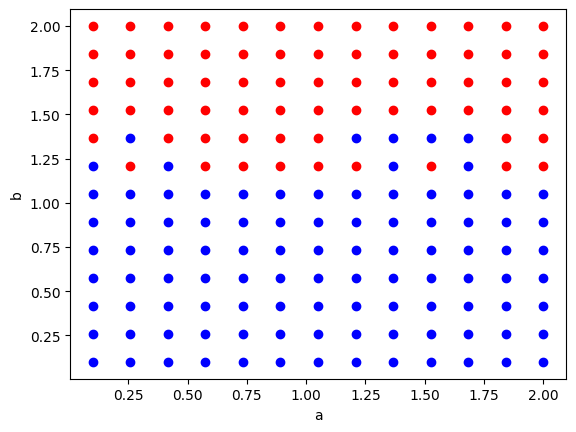

In [ ]:
legend_keys = []
for key_num_timesteps, val_a_and_b_tuples_list in sim_length_to_a_and_b_tuple_dict.items():
  legend_keys.append(key_num_timesteps)


  temp_array = np.array(val_a_and_b_tuples_list)
  # print("total timesteps",key_num_timesteps)
  # print(temp_array)
  if key_num_timesteps > 50:
    print(val_a_and_b_tuples_list)
    format_str = 'or'
  else:
    format_str = 'ob'

  all_a_vals = temp_array[:,0]

  all_b_vals = temp_array[:,1]

  plt.plot(all_a_vals,all_b_vals,format_str)

plt.xlabel('a')
plt.ylabel('b')
plt.show()

In [ ]:
# a = 100
# b = 1.8

a, b = (0.4, 1.7)
all_timesteps = simulate_system(num_dim=2,t=100,init_states=init_states,a=a,
                                b=b,tri=tri,R_max=R_max_2d,
                                p_0=p_0_2d/4,adjacency_mtx = adjacency_mtx,
                                center_of_tumor_pt = center_of_tumor_pt,
                                center_of_tumor_idx = center_of_tumor_idx)

print("total timesteps:",len(all_timesteps))
# all_timesteps[-1]

total timesteps: 101


total number of steps: 101
ten_percent_rounded: 25


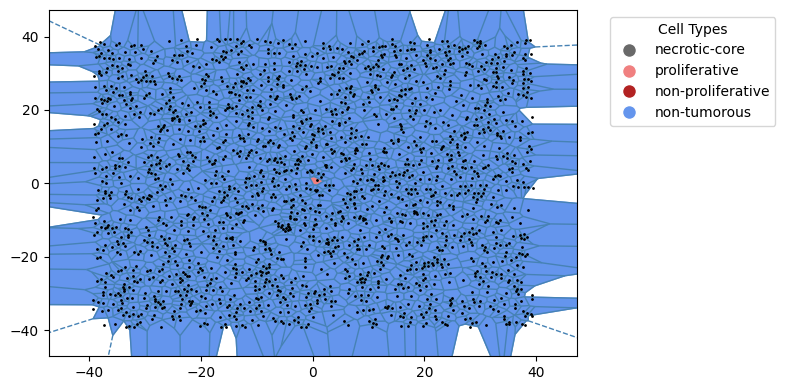

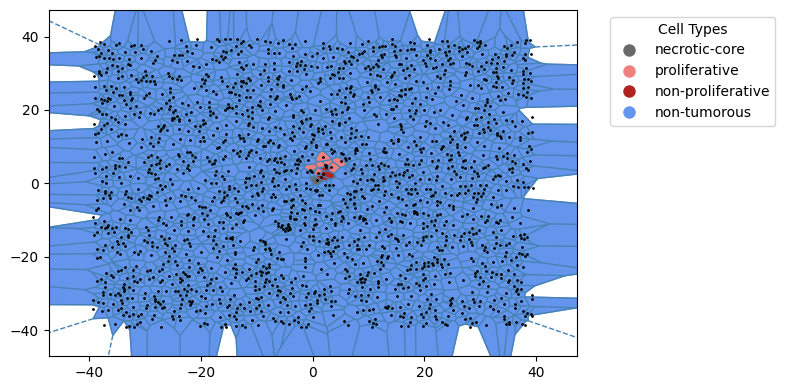

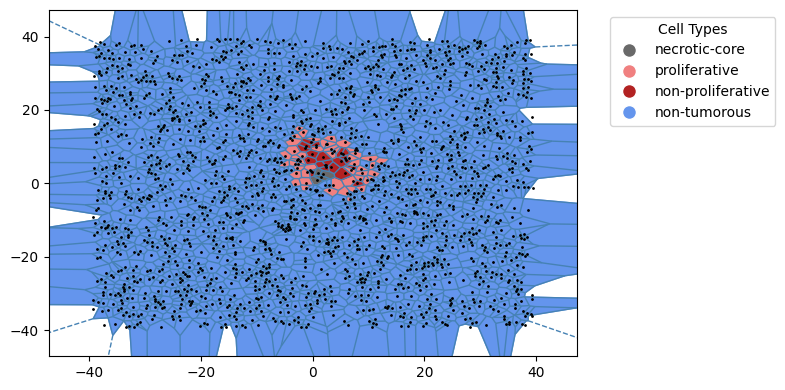

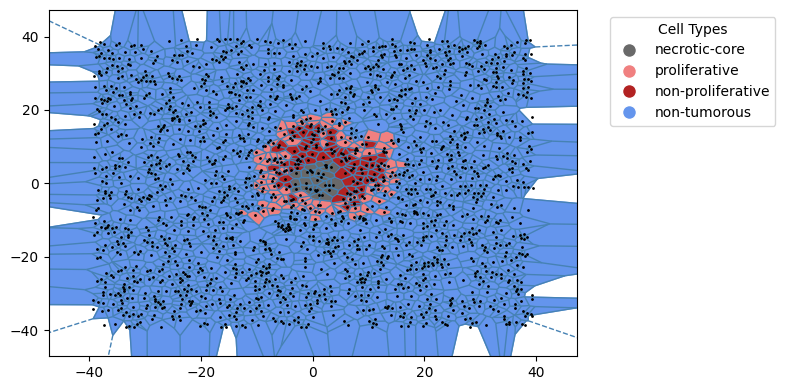

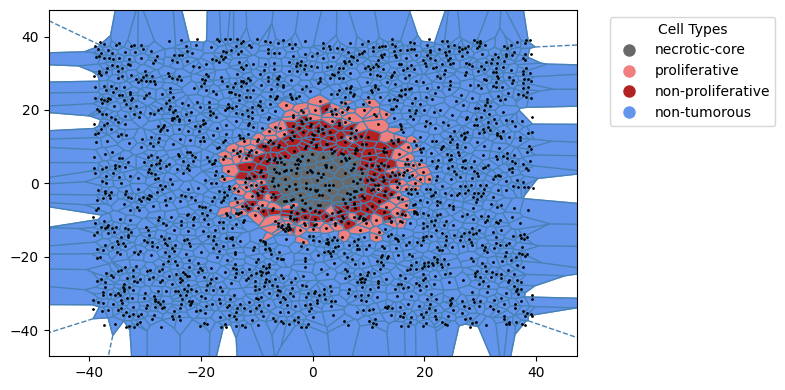

In [ ]:
# num_timesteps = len(all_timesteps)
# ten_percent = int(num_timesteps/10)

total_steps = len(all_timesteps)
print("total number of steps:",total_steps)

ten_percent = total_steps/4
ten_percent_rounded = int(ten_percent)
print("ten_percent_rounded:",ten_percent_rounded)

for idx, timestep_states in enumerate(all_timesteps):

  # if there's less than 10 timesteps, plot them all
  if total_steps < 10 and idx != 0:
    plot_current_timestep(states_to_labels_dict=states_to_labels_dict,
                          cur_timestep_states=timestep_states,
                          all_rsa_points=small_set)
  # plots the first, then every 10%, then final timestep
  if ten_percent_rounded != 0:
    if idx % ten_percent_rounded == 0:
        plot_current_timestep(states_to_labels_dict=states_to_labels_dict,
                            cur_timestep_states=timestep_states,
                            all_rsa_points=small_set)

plt.show()

In [ ]:
# # num_timesteps = len(all_timesteps)
# # ten_percent = int(num_timesteps/10)

# total_steps = len(all_timesteps)

# ten_percent = total_steps/10
# ten_percent_rounded = int(ten_percent)
# # print(ten_percent)

# # add 2 for the first and final plot
# total_plots = int(total_steps/ten_percent) + 1

# # for idx, timestep_states in enumerate(all_timesteps):

# #   # plots the first and then every 10th timestep
# #   if idx % 10 == 0:
# #     plot_current_timestep(states_to_labels_dict=states_to_labels_dict,
# #                           cur_timestep_states=timestep_states,
# #                           all_rsa_points=small_set)


# #   # if there's less than 10 timesteps, plot them all
# #   if total_steps < 10 and idx != 0:
# #     plot_current_timestep(states_to_labels_dict=states_to_labels_dict,
# #                           cur_timestep_states=timestep_states,
# #                           all_rsa_points=small_set)

# # Number of plots
# num_plots = total_plots
# # print(total_plots)
# # Define the number of rows and columns for the subplot grid
# num_rows = 6  # You can adjust this based on your preference
# num_cols = 2

# # Create a figure and axis objects using subplots
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 12))

# # Flatten the axs array if the subplot grid is more than 1 row
# axs = axs.flatten()

# plot_i = 0
# # Loop through each subplot
# for idx, timestep_states in enumerate(all_timesteps):

#   # plots the first, then every 10%, then final timestep
#   if (idx % ten_percent_rounded == 0 or idx == total_steps - 1)  and plot_i <= total_plots:
#     plot_current_timestep(states_to_labels_dict=states_to_labels_dict,
#                           cur_timestep_states=timestep_states,
#                           all_rsa_points=small_set,
#                           fig=fig,
#                           ax = axs[plot_i])

#     print(idx)
#     # Set a title for each subplot if needed
#     axs[plot_i].set_title(f'Plot {plot_i+1}')
#     plot_i += 1

# # Adjust layout to prevent clipping of titles
# plt.tight_layout()

# # Show the plot
# plt.show()
